## <font color=Green>GMD Figure 7 </font>  
#### <font color=blue> *Extreme sea-level return-period curve* PLOT </font>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4 as nc
from pandas.plotting import table 
import xarray as xr
#
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
#
colrs = 'rcbgmyrkcbgm'

#### <font color=black> *Define* Functions </font>

In [2]:
def IP_nc(df,wf1e,SCENARIO,EXPDATE):
    #  
    a = [];     ccomp = []
    MODNO = df.index.values;   # Number of datasets Module outputs
    #
    for scenario in SCENARIO:
        for wf in wf1e: 
            #
            # Pick Component acording to workflow.
            COMP = wf.split("-")[0]; MODULE = wf.split("-")[1]; 
            val = df.index[ (df['Component'] == COMP) & (df['Module'] == MODULE) ].values[0]
            SUB_MODULE = df["sub_Module"][val];  DATAFILE   = df["DataFile"][val];
            valIND = 0
            #       
            # Skip if data is absent.
            if df["DataFile"][val] == 'XXX':
                continue 
            #
            # Pick the data files & Import nc file to dataframe. 
            if SCENARIO[0][:3] == 'ssp':
                dataFOLDER  = '/projects/kopp/facts-experiments/{arg2}/coupling.{arg1}/output/'.format(arg1=scenario,arg2=EXPDATE)
                dataFILE    = 'coupling.{arg1}.'.format(arg1=scenario) + df["DataFile"][val]
            elif SCENARIO[0][:3] == 'rcp':
                dataFOLDER  = '/projects/kopp/facts-experiments/{arg2}/ar5k14.{arg1}/output/'.format(arg1=scenario,arg2=EXPDATE)
                dataFILE    = 'ar5k14.{arg1}.'.format(arg1=scenario) + df["DataFile"][val]
            d_nc        = xr.open_dataset(dataFOLDER + dataFILE)
            #print( "DataFILE ==> "+str(df["DataFile"][val])+"\n"+ str(d_nc.dims) + "\n" + str(d_nc.data_vars)+ "\n" + str(d_nc.coords)+"\n"+"-------------"+"\n"+"\n" )
            #
            # Index for time.
            ST = 2020 ; EN = 2100
            YindST = np.where(d_nc["years"].values == ST)[0][0];   YindEN = np.where(d_nc["years"].values == EN)[0][0]
            # Save data into a new variable.
            ccomp.append(COMP)
            b = d_nc.sea_level_change[:,YindST:YindEN+1,0].values
            a.append(b[None,:] )
    #stack all at once
    sampsloccomponents = np.vstack(a);  sampsloccomponents = np.transpose(sampsloccomponents,(1,0,2))
    yrs=d_nc.years[YindST:YindEN+1].values
    #
    sampslocrise = np.sum(sampsloccomponents[:,:,:],axis=1)
    #
    return sampsloccomponents, sampslocrise, ccomp, yrs; 

In [3]:
sitelab='New York';
selectedSite = 12;      #PSMSL ID for NYC
threshold = 0.5148;     #GPD threshold
scale = 0.1285;         #GPD scale
shape = 0.188;          #GPD shape
llambda = 2.8085;        #Poisson Lambda


#### <font color=blue> Load Module data from </font> <mark> facts-experiments </mark>

In [4]:
# Load FACTS workflow data as a dataframe.
#
# df_G = pd.read_fwf('../001_GMD_IP_Modules_Data/ModuleTest_DataFile_List_coupling.txt',comment = '#')
df_L = pd.read_fwf('../001_GMD_IP_Modules_Data/ModuleTest_DataFile_List_coupling.local.txt',comment = '#')
#
# df_ark_G = pd.read_fwf('../001_GMD_IP_Modules_Data/ModuleTest_DataFile_List_ar5k14-221217.txt',comment = '#')
# df_ark_L = pd.read_fwf('../001_GMD_IP_Modules_Data/ModuleTest_DataFile_List_ar5k14.local-221217.txt',comment = '#')
#df

# <font color=green> **Coupling** *(Global\&Local)* </font>

In [5]:
EXPDATE     = 221217
SCENARIO    = ['ssp585'];
# Workflow Components.
wf1e = ['AIS-emulandice', 'GrIS-emulandice', 'TE-tlm','Glaciers-emulandice',  'LWS-ssp']
#
# df = df_G;      [sampsloccomponents_G, ccomp_G, yrs] = IP_nc(df,wf1e,SCENARIO,EXPDATE);
df = df_L;      [sampsloccomponents_L, sampslocrise, ccomp_L, yrs] = IP_nc(df,wf1e,SCENARIO,EXPDATE);
#
#
samps = np.hstack((np.zeros((sampslocrise.shape[0],1)),sampslocrise)) / 1000

# Translate later ==>samps=bsxfun(@min,samps,quantile(samps,.999)); % truncate samples viewed as physically implausible
#qsamps = np.quantile(samps, .999,axis=0)

yrs = np.insert(yrs, 0, 2010, axis=0)

testz = np.arange(0, 10+0.01, 0.01)

In [6]:
ESLR = np.mean(samps,axis=0)
SLR50=np.quantile(samps,.5,axis=0)
SLR999=np.quantile(samps,.999,axis=0)

In [7]:
def GPDLogNExceedances(z,llambda,shape,scale,MHHW):
    #
    z0 = z
    z = np.maximum(z, 0)  #z[z<0] = 0
    #
    if shape<0:
        z=np.minimum(z,.99999*-scale/shape,z)
        logN = np.log(llambda*(1+(shape)*z/scale)**(-1/(shape)))
    elif shape==0:
        logN = np.log(llambda)-z/scale
    else:
        logN = np.log(llambda*(1+(shape)*z/scale)**(-1/(shape)))
    #    
    y= logN

    # (not using this since MHHW for NYC == 0.5148)
    # for those points below threshold to MHHW, put on a Gumbel.
    # if np.max(MHHW.shape)>=1:
    # np.maximum(z0, MHHW(1), z0)
    z0=np.maximum(z0, MHHW) 
    sub = np.argwhere(z0<0)
    #if np.max(MHHW.shape)>=2:
    #    MHHWfreq=MHHW(2); 
    #else:
    MHHWfreq=365.25/2  
    # y(sub) = np.log(llambda)+(np.log(MHHWfreq)-np.log(llambda))*z0(sub)/MHHW(1)
    y[tuple(sub.T)] = np.log(llambda)+(np.log(MHHWfreq)-np.log(llambda))*z0[tuple(sub.T)]/MHHW
    #
    return y    

In [8]:
histcurve=np.exp(GPDLogNExceedances(testz-threshold,llambda,shape,scale,-threshold))

In [12]:
effcurve = np.empty((yrs.shape[0],testz.shape[0],)); effcurve[:] = np.nan
#
for tt in enumerate(yrs):
    # print(tt[0])
    gg  = testz[np.newaxis] - samps[:,tt[0]][np.newaxis].T
    gg1 = np.real(np.mean(np.exp(GPDLogNExceedances(gg-threshold,llambda,shape,scale,-threshold)),axis=0))
    effcurve[tt[0],:] = gg1.T
    





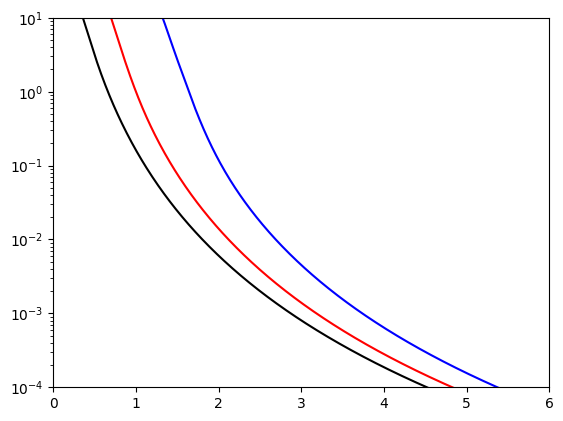

In [17]:
plt.plot(testz, histcurve, '-k')
plt.plot(testz, effcurve[4,:], '-r')
plt.plot(testz, effcurve[9,:], '-b')
#
plt.yscale("log")
#
ax = plt.gca()
ax.set_xlim([0, 6])
ax.set_ylim([1e-4, 10])
#
plt.show()

In [ ]:
ans = samps[:,9][np.newaxis].T
# ans = testz[np.newaxis]

# <font color=black> **=======================================================================** </font>

In [ ]:
# % Breakdown the above.
# % for ttt=1:length(targyears)
    # gg = (bsxfun(@minus,testz,samps(:,21)));
# %     gg = (bsxfun(@minus,testz,samps(:,ttt)));
    gg1 = logN(gg);
    gg2 = exp(gg1);
    gg3 = mean(gg2,1);
    gg4 = real(gg3);

    gg11 = GPDLogNExceedances(gg-threshold,lambda,shape,scale,-threshold);
    gg22 = exp(gg11);
    gg33 = mean(gg22,1);
    gg44 = real(gg33);

In [ ]:
z0 = testz-threshold
np.maximum(z0, -threshold, z0)
sub = np.argwhere(z0<0)
MHHWfreq=365.25/2

In [ ]:
# Use only is shape is <=1
gg = np.array(threshold)

In [ ]:
gg = np.array([[2,4,6],[1,3,3]])
gg1=np.zeros(gg.shape)
sub=np.argwhere(gg<4)

In [ ]:
np.maximum(gg, 5, gg)

In [ ]:
# gg[sub] = 999
gg1[tuple(sub.T)] = gg[tuple(sub.T)] + 999

In [ ]:
import numpy as np
a = np.array([5,4])[np.newaxis]
print(a)
a2 = a.T

# <font color=black> **=======================================================================** </font>